In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

import tensorflow as tf

pd.options.display.max_columns = None

In [33]:
df_covid = pd.read_csv('./Covid_clean.csv')

C:\Users\ismael\AppData\Local\Temp\ipykernel_8140\3510291388.py:1: DtypeWarning: Columns (4,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid = pd.read_csv('./Covid_clean.csv')


In [34]:
# creamos el modelo de clasificacion

features = ['SEX', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
target = 'fallecidos'




# Rebalanceo y xGboost


In [35]:
clase_mayoritaria = df_covid[df_covid['fallecidos'] == 0]
clase_minoritaria = df_covid[df_covid['fallecidos'] == 1]

clase_mayoritarial_downsampled = resample(clase_mayoritaria,
                                            replace = False,
                                            n_samples = len(clase_minoritaria),
                                            random_state = 42)

df_covid_downsampled = pd.concat([clase_mayoritarial_downsampled, clase_minoritaria])

df_covid_downsampled['fallecidos'].value_counts()

fallecidos
0    74612
1    74612
Name: count, dtype: int64

In [36]:
X = df_covid_downsampled[features]
y = df_covid_downsampled[target]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Definición de los hiperparámetros a ajustar
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}

# Instancia de Grid Search Cross Validation
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)

# Entrenamiento del modelo con Grid Search
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evaluación del modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.8550175908862456


Accuracy: 0.8550175908862456
Precision: 0.8456030723166048
Recall: 0.8691957714438646
F1: 0.8572371242865156


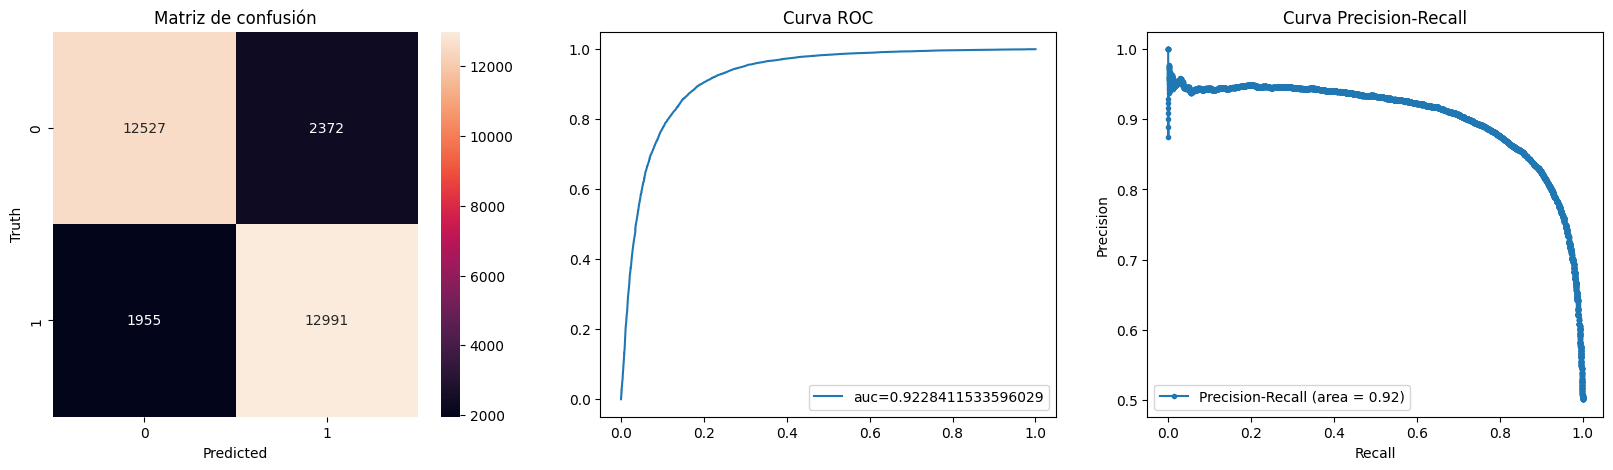

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1:", f1)


# grafiocamos la matriz de confusión

cm = confusion_matrix(y_test, y_pred)

# Curva ROC

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Curva Precision-Recall

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# ploteo los 3 graficos en un mosaico

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Truth')
ax[0].set_title('Matriz de confusión')

ax[1].plot(fpr,tpr,label="auc="+str(auc))
ax[1].legend(loc=4)
ax[1].set_title('Curva ROC')

ax[2].plot(recall, precision, marker='.', label='Precision-Recall (area = %0.2f)' % auc)
ax[2].legend(loc="lower left")
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Curva Precision-Recall')


plt.show()

Sin mejoras de hiperparametros

Accuracy: 0.8533708618147702
Precision: 0.8417811770806326
Recall: 0.8703256936067552
F1: 0.8558154859967051

Accuracy: 0.8550175908862456
Precision: 0.8456030723166048
Recall: 0.8691957714438646
F1: 0.8572371242865156